In [1]:
import dill
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from gensim.models.word2vec import Word2Vec
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model, load_model
from keras.layers import Input,Dense, Embedding, Reshape, Conv1D, MaxPooling1D, LSTM
from keras.layers import Dot, Multiply, Concatenate, Activation, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

c:\users\jiazhi\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\jiazhi\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17142812490500437767
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4971180851
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4784671460852087911
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Sentence Scoring

### 讀取資料並打亂訓練集

In [2]:
train_df = pd.read_pickle("data/train_set.pkl").sample(frac=1.0)
valid_df = pd.read_pickle("data/valid_set.pkl")
test_df = pd.read_pickle("data/test_set.pkl")

## 讀取Word2Vec至Embedding層

In [3]:
w2v_model = Word2Vec.load('word2vec/d50-sg1-iter10.model')
vocab_list = [(word, w2v_model.wv[word]) for word, _ in w2v_model.wv.vocab.items()]

### 以詞向量平均值作為未知詞的向量

In [4]:
UNK = len(vocab_list) + 1
UNK_vec = np.array([vec for _, vec in vocab_list]).mean(axis=0)
print("UNK:", UNK)

UNK: 313475


### 建立Tokenizer與Embedding的權重

In [5]:
word2token = defaultdict(lambda: 313475)
emb_weights = np.zeros((len(vocab_list)+2, w2v_model.vector_size))

for i, vocab in enumerate(vocab_list, start=1):
    word, vec = vocab
    word2token[word] = i
    emb_weights[i] = vec
    
word2token['<L>'] = word2token['<R>'] = 0
emb_weights[UNK] = UNK_vec

In [6]:
embedding_layer = Embedding(input_dim=emb_weights.shape[0], output_dim=emb_weights.shape[1],
                            weights=[emb_weights], trainable=False)

In [7]:
with open("helper/word2token.dill", 'wb') as file:
    dill.dump(word2token, file)

## 資料處理

In [8]:
M, N = 5, 5

def get_sen_labels():
    sen_labels = []
    for i in reversed(range(M)):
        sen_labels.append('stm'+str(i+1))
    sen_labels.append('st')
    for i in range(N):
        sen_labels.append('stn'+str(i+1))
    return sen_labels

### 以訓練集裡99.7%的句子長度作為padding length

In [9]:
pad_len = int(np.percentile(train_df.st.apply(len).values, 99.7) - 2)
print("※ 99.7%%的句子，長度不超過 %d 個詞" % pad_len)

※ 99.7%的句子，長度不超過 46 個詞


In [10]:
with open("helper/pad_len.pkl", 'wb') as file:
    pickle.dump(pad_len, file)

### tokenizing & padding

In [11]:
def tokenizing(text):
    return [word2token[word] for word in text]
def process_text(text):
    return pad_sequences(text.apply(tokenizing), maxlen=pad_len, padding='post', truncating='post')

### 處理資料成模型的輸入格式

In [12]:
def get_inputs(df):
    inputs = {}
    for label in get_sen_labels():
        inputs[label] = process_text(df[label])
    inputs['sf'] = np.array(df[['len', 'pos', 'tf', 'df']])
    return inputs

In [13]:
%%time
X_train = get_inputs(train_df)
Y_train = train_df.rouge_2.values.reshape(-1, 1)
X_valid = get_inputs(valid_df)
Y_valid = valid_df.rouge_2.values.reshape(-1, 1)
X_test = get_inputs(test_df)
Y_test = test_df.rouge_2.values.reshape(-1, 1)

Wall time: 1min 55s


## 建立神經網路模型

In [14]:
def get_att_sentence(name, conv_layer, st):
    inp = Input(shape=(pad_len,), name=name)
    emb = embedding_layer(inp)
    conv = conv_layer(emb)
    weight = Activation('softmax') (Dot(axes=2, normalize=True) ([conv, st]))
    att = Multiply() ([weight, conv])
    mp = MaxPooling1D(pad_len-1) (att)
    return inp, mp

In [15]:
def new_model(m=5, n=5, sentence_dim=50, dense_dim=100, dense_depth=3, dropout=0.1, use_crsum=True, use_sf=True):
    inputs = []
    
    # surface features
    sf = Input(shape=(4,), name='sf')
    inputs.append(sf)
    
    if use_crsum:
        # current sentence modeling
        inp_st = Input(shape=(pad_len,), name='st')
        emb_st = embedding_layer(inp_st)
        conv_layer = Conv1D(sentence_dim, 2, activation='tanh')
        conv_st = conv_layer(emb_st)
        st = MaxPooling1D(pad_len-1) (conv_st)
        st_flatten = Flatten() (st)
        inputs.append(inp_st)

        # other sentences modeling
        pc = []
        for i in reversed(range(1, m+1)):
            name = 'stm'+str(i)
            inp, sen = get_att_sentence(name, conv_layer, st)
            inputs.append(inp)
            pc.append(sen)

        fc = []
        for i in range(1, n+1):
            name = 'stn'+str(i)
            inp, sen = get_att_sentence(name, conv_layer, st)
            inputs.append(inp)
            fc.append(sen)

        # context relation modeling
        lstm_layer = LSTM(sentence_dim, return_sequences=True, recurrent_dropout=dropout)

        h_pc, h_fc = [], []
        for sen in pc:
            h_pc.append(lstm_layer(sen))
        h_st = lstm_layer(st)
        for sen in fc:
            h_fc.append(lstm_layer(sen))

        h_pc = Concatenate(axis=1) (h_pc)
        w_pc = Activation('softmax') (Dot(axes=2, normalize=True) ([h_pc, h_st]))
        att_pc = Multiply() ([w_pc, h_pc])
        mp_pc = MaxPooling1D(m) (att_pc)
        cos_pc = Flatten() (Dot(axes=2, normalize=True) ([mp_pc, st]))

        h_fc = Concatenate(axis=1) (h_fc)
        w_fc = Activation('softmax') (Dot(axes=2, normalize=True) ([h_fc, h_st]))
        att_fc = Multiply() ([w_fc, h_fc])
        mp_fc = MaxPooling1D(n) (att_fc)
        cos_fc = Flatten() (Dot(axes=2, normalize=True) ([mp_fc, st]))
    
    if use_crsum and use_sf:
        main = Concatenate() ([cos_pc, cos_fc, st_flatten, sf])
    elif use_crsum:
        main = Concatenate() ([cos_pc, cos_fc, st_flatten])
    elif use_sf:
        main = sf
    else:
        print("Error: at least either CRSum or SF should be used.")
    
    main = BatchNormalization() (main)
    for _ in range(dense_depth):
        main = Dropout(dropout) (Dense(dense_dim, activation='relu') (main))
    output = Dense(1) (main)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

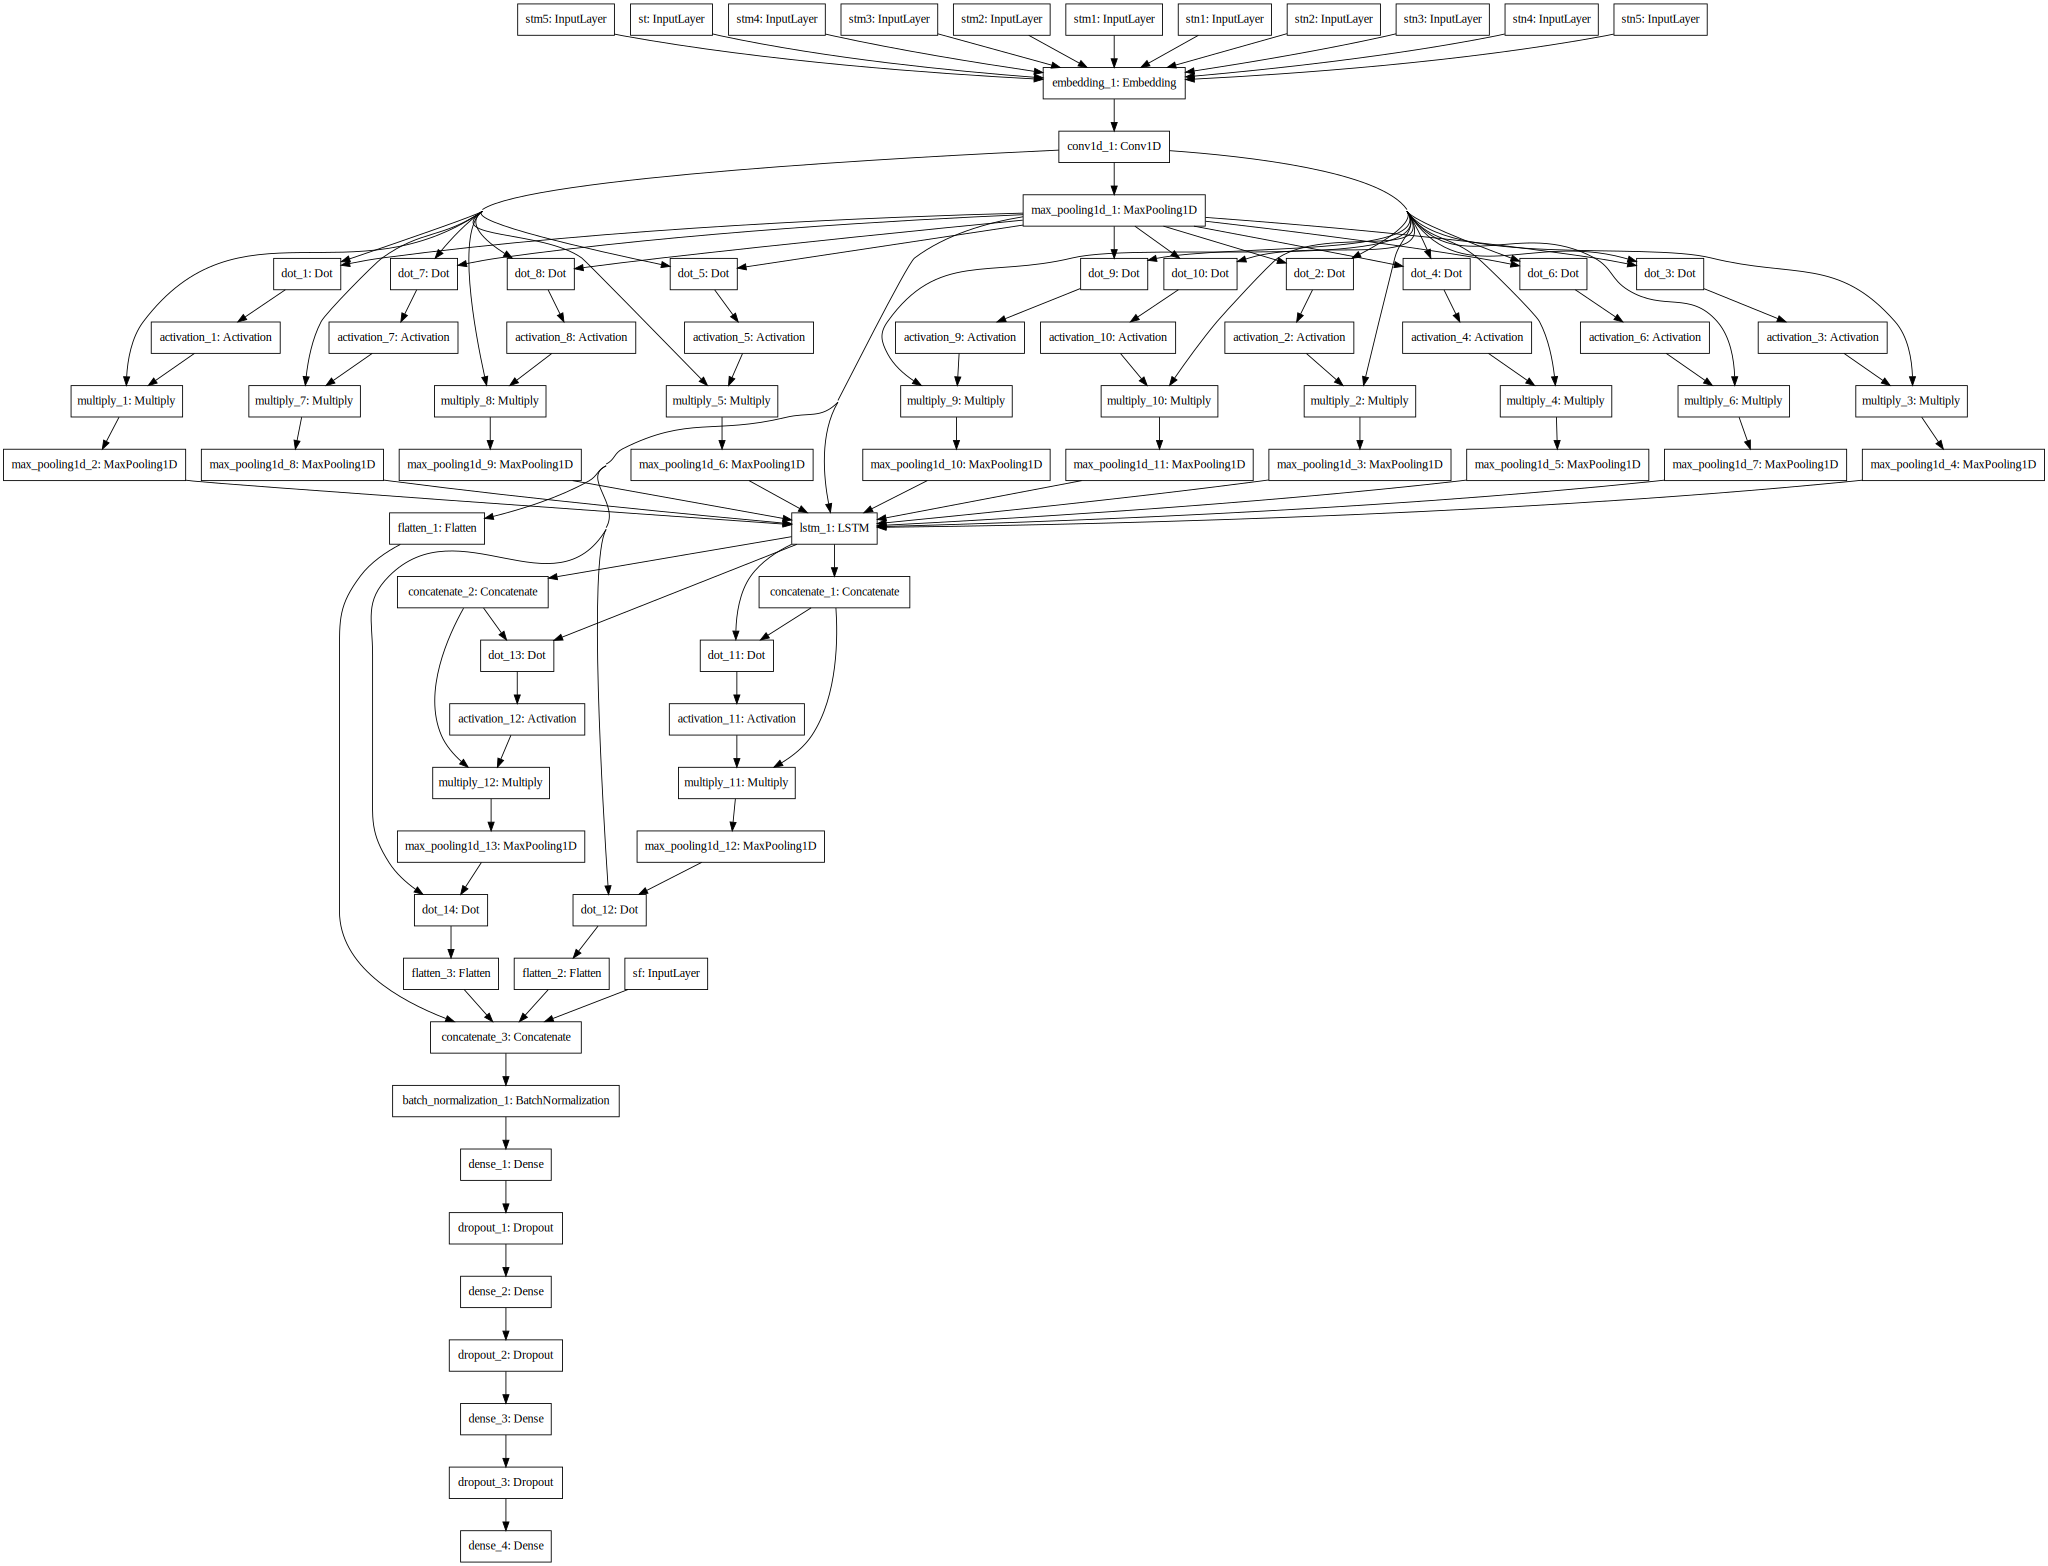

In [16]:
model = new_model()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 訓練CRSum+SF模型

In [17]:
%%time
filepath = "model/epoch{epoch:03d}-{loss:.8f}-{val_loss:.8f}.h5"
callbacks = [ModelCheckpoint(filepath)]
model = new_model(use_crsum=True, use_sf=True)
model.fit(X_train, Y_train, batch_size=2048, epochs=10, validation_data=(X_valid, Y_valid), callbacks=callbacks)

Train on 1249873 samples, validate on 155691 samples
Epoch 1/10
1249873/1249873 [==============================] - 163s 130us/step - loss: 0.0058 - val_loss: 0.0023
Epoch 2/10
1249873/1249873 [==============================] - 156s 125us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/10
1249873/1249873 [==============================] - 155s 124us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/10
1249873/1249873 [==============================] - 155s 124us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/10
1249873/1249873 [==============================] - 156s 124us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/10
1249873/1249873 [==============================] - 155s 124us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/10
1249873/1249873 [==============================] - 157s 126us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/10
1249873/1249873 [==============================] - 157s 126us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/10
1249873/1249873 [=======================

In [18]:
# Load model with best valid loss
model = load_model("model/crsum_sf.h5")

### 用測試集評估模型表現

In [19]:
%%time
test_df['rouge_2_pred'] = model.predict(X_test)
loss = model.evaluate(X_train, Y_train)
val_loss = model.evaluate(X_valid, Y_valid)
test_loss = mean_squared_error(test_df.rouge_2, test_df.rouge_2_pred)

155691/155691 [==============================] - 34s 221us/step
Wall time: 6min 17s


In [20]:
print("           train   |  valid   |  test")
print("CRSum+SF: %6f - %6f - %6f" % (loss, val_loss, test_loss))

           train   |  valid   |  test
CRSum+SF: 0.001966 - 0.002039 - 0.002036


# Sentence Selection

In [21]:
summary_df = pd.read_pickle("data/summary.pkl")
corpus_df = pd.read_pickle("data/corpus.pkl")

In [22]:
def length_of(df):
    try:
        return df.st.apply(lambda x: len(x[1:-1])).sum()
    except:
        return 0

In [23]:
def get_bigrams(sen):
    bigram = set()
    for i in range(0, len(sen)-1):
        bigram.add((sen[i], sen[i+1]))
    return bigram

In [24]:
def bigram_overlap(st_df, psi_df):
    try:
        st = [word for st in st_df.st.values for word in st[1:-1]]
        psi = [word for st in psi_df.st.values for word in st[1:-1]]
        st_bigrams = get_bigrams(st)
        psi_bigrams = get_bigrams(psi)

        overlap = 0
        for bigram in st_bigrams:
            overlap += bigram in psi_bigrams
        return overlap / len(st)
    except:
        return 0

In [25]:
def get_summary(df, rouge_2_label, maxlen=33, redundancy=0.3, ordered=1):
    rouge2 = df[rouge_2_label].values
    
    psi_df = pd.DataFrame()
    while np.max(rouge2) != -1 and length_of(psi_df) < maxlen:
        sen = np.argmax(rouge2)
        rouge2[sen] = -1
        
        sen_df = df[df.sen == sen][['sen', 'st']]
        if length_of(psi_df) + length_of(sen_df) > maxlen:
            continue
        if bigram_overlap(sen_df, psi_df) <= redundancy:
            psi_df = pd.concat((psi_df, sen_df))
    
    try:
        if ordered:
            psi_df = psi_df.sort_values('sen')
        return [word for st in psi_df.st.values for word in st[1:-1]]
    except:
        return []

In [26]:
def rouge_1(y_true, y_pred):
    y_true_set = set(y_true)
    y_pred_set = set(y_pred)
    
    overlap = 0
    for word in y_pred_set:
        overlap += word in y_true_set
    return overlap / len(y_true_set)

In [27]:
def rouge_2(y_true, y_pred):
    y_true_bigrams = get_bigrams(y_true)
    y_pred_bigrams = get_bigrams(y_pred)
    
    overlap = 0
    for bigram in y_pred_bigrams:
        overlap += bigram in y_true_bigrams
    return overlap / len(y_true_bigrams)

## 計算測試集摘要的平均ROUGE-1/2成績

In [28]:
crsum_sf_rouge1, crsum_sf_rouge2 = 0, 0
for id in test_df.id.unique():
    doc_df = test_df[test_df.id == id].sort_values('sen')

    # get real and predicted summary
    summary = summary_df.loc[summary_df.id == id].summary.values[0]
    crsum_sf_summary = get_summary(doc_df, 'rouge_2_pred')

    # calculate ROUGE-1/2
    crsum_sf_rouge1 += rouge_1(summary, crsum_sf_summary)
    crsum_sf_rouge2 += rouge_2(summary, crsum_sf_summary)

crsum_sf_rouge1 /= len(test_df.id.unique())
crsum_sf_rouge2 /= len(test_df.id.unique())
print("ROUGE-1/2: %.2f/%.2f" % (crsum_sf_rouge1*100, crsum_sf_rouge2*100))

ROUGE-1/2: 31.68/10.93


## 隨機抽樣，檢視內文、標題、摘要

In [29]:
def generate_summary(num=5):
    id_list = test_df.id.unique()
    for i, id in enumerate(np.random.choice(id_list, num), start=1):
        raw_summary = corpus_df[corpus_df.id == id].summary.values[0]
        raw_document = corpus_df[corpus_df.id == id].document.values[0]
        summary = summary_df[summary_df.id == id].summary.values[0]

        doc_df = test_df[test_df.id == id].sort_values('sen')
        predict_summary = get_summary(doc_df, 'rouge_2_pred')

        print("%d." % i)
        try:
            print("〈標題〉：%s" % raw_summary)
            print("〈摘要〉：%s\n" % "".join(predict_summary))
            print("〈內文〉：%s" % raw_document)
        except:
            print("An error has occured!")
            
generate_summary()

1.
〈標題〉：台股一度狂跌602點 盤中史上第4大跌點
〈摘要〉：今天盤中狂跌602.22點，根據統計，已經創下台股史上盤中第4大跌點，史上盤中最大跌點落在1990年2月26日，

〈內文〉：今天盤中狂跌602.22點，根據統計，已經創下台股史上盤中第4大跌點，跌勢相當驚人。根據Cmoney資訊，史上盤中最大跌點落在1990年2月26日，當天盤中一度大跌639.37點，還有2次盤中大跌超過600點的記錄，分別是1990年4月7日盤中下跌623.18點及2000年3月23日盤中下跌622.24點。台股今天受到美國大跌1175.21點、跌幅4.6%的重擊，在11時46分時盤中最低跌至10344.03點，跌幅達5.5%，不但跳空跌破季線10761點，也直接摜破半年線10677點，直探年線10386點，由於美股電子盤續跌超過500點，也讓台股盤中欲振乏力，出現爆量重挫的走勢。此外，2000年4月15日盤中一度跌594.53點、1990年5月1日盤中一度下跌586.44點，2015年8月24日盤中一度下跌583.85點。分析師表示，台股今天重挫，盤中引發程式賣壓，成交值也恐怕爆出超過2400億元，可望創近9年天量，台股在連續2個交易日大跌逾760點後，已經將今年以來的漲幅全數吐光。
&nbsp


2.
〈標題〉：鉛價漲＋美元收支自動避險 泰銘今年營運挑戰高峰
〈摘要〉：而鉛冶煉廠泰銘 (9927) 則受惠「美元收支」產生自動避險效益，泰銘指出，泰銘今年營收料可挑戰去年高峰。

〈內文〉：近期弱勢美元助長新台幣升勢，國內出口商叫苦連天，而鉛冶煉廠泰銘 (9927)
則受惠「美元收支」產生自動避險效益，因此不受匯損影響；泰銘指出，公司應收及應付帳款皆以美元計價，會將美元收入直接當成購料成本，帳上銷貨成本則隨之下降，加上國際鉛錠價仍處高檔整理，未來營運有望持續攀升。法人認為，泰銘今年營收料可挑戰去年高峰。泰銘去年受惠
LME 國際鉛價上揚逾兩成，全年營收達 108.48 億元，創歷史新高，毛利率更升至逾 12%，較往年平均值 10%
明顯提升。泰銘表示，今年原物料若能維持在 2300 美元 / 公噸，則可維持高水準之毛利率，營收也有望挑戰去年高點。國際鉛錠價格往年均值皆處 2000 美元
/ 公噸以下，去年均值達 2317 美元 /
公噸，挹注平均銷售單價（ASP）提升，泰銘表